In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

# Naive Bayes Classifier

In [2]:
class NBC:
    # class representing the naive bayes clasifier (NBC)
    
    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types  # list of feature types; so far only 'r' for 'real' supported
        self.num_classes = num_classes  # number of classes to clasify
        
    def fit(self, Xtrain, ytrain):
        # determines the parametres for the NBC model
        # a Gaussian is used to model these parameters, therefore the empirical mean and variance get stored as params
        self.means = None # means of every feature in the dataset, by class
        self.variances = None # variances of every teature in the dataset, by class
        self.y_params = None # parameters to determine probability of classes y
        self.N_c = None      # number of examples for each class c
        self.N = Xtrain.shape[0]  # total number of examples = number of rows in X
        for c in range(self.num_classes):
            #determine y_params -- empirical ratio of #(y=c)/N
            N_c = np.sum(ytrain == c)
            y_param_c = N_c/self.N
            y_param_c = y_param_c if y_param_c != 0 else 1e-6  # replace 0 with small value to avoid log(0)
            if self.N_c is None:
                self.N_c = np.array([N_c])
            else:
                self.N_c = np.append(self.N_c, [N_c])
            if self.y_params is None:
                self.y_params = np.array([y_param_c])
            else:
                self.y_params = np.append(self.y_params, [y_param_c])
                
            # determine variance and mean for every feature and class -- params for x
            X_c = Xtrain[ytrain==c] # TODO: adapt this so that c can be arbitrary, not in range(num_classes)
            means_c, variances_c = X_c.mean(axis=0), X_c.var(axis=0)
            variances_c = np.array([1e-6 if var == 0 else var for var in variances_c])  # avoid division by 0
            if self.means is None:
                self.means = np.array([means_c])
            else:
                self.means = np.append(self.means, [means_c], axis=0)
            if self.variances is None:
                self.variances = np.array([variances_c])
            else:
                self.variances = np.append(self.variances, [variances_c], axis=0)
                
    def predict(self, x_new):
        # predicts a class (y) for a feature vector (x_new)
        if x_new.ndim == 1:
            x_new = np.array([x_new])  # convert single feture vector to matrix
        n = len(x_new)
        winning_class, winning_stat = -1 * np.ones(n), float('-inf') * np.ones(n)
        denominator = 0  # denominator in the bayesian posterior expression
        for c in range(self.num_classes):
            mean, var = self.means[c], self.variances[c]  # arrays of means and vars for every feature in x_new
            for i in range(n):  # TODO: remove loop for matrix operation
                log_p_x_given_yc = np.sum(np.log(self.gaussian(x_new[i], mean, var)))  # log likelihood of x_new given y = c
                log_p_yc = np.log(self.y_params[c])  # log prior of y = c
                log_p_xyc = log_p_x_given_yc + log_p_yc  # log probability of x_new and y = c; numerator of posterior
                denominator += np.exp(log_p_xyc) # only used to return actual probability for y
                if log_p_xyc > winning_stat[i]:
                    winning_class[i], winning_stat[i] = c, log_p_xyc
        return winning_class
        #return winning_class, np.exp(winning_stat) / denominator
    
            
    def gaussian(self, val, mean, var):
        f = (1 / (np.sqrt(var)*np.sqrt(2*np.pi))) * np.exp(-(1/2) * (((val-mean)/np.sqrt(var))) ** 2)
        # replaces 0s to avoid log(0)
        return f + [1e-6 if x == 0 else 0 for x in f]
        

In [3]:
# load dataset and fit model
iris = load_iris()
X, y = iris['data'], iris['target']

nbc = NBC(feature_types=['r', 'r', 'r'], num_classes=3)
nbc.fit(X[0], y[0])

<ipython-input-2-49e94e6f558f>:32: RuntimeWarning: Mean of empty slice.
  means_c, variances_c = X_c.mean(axis=0), X_c.var(axis=0)
/home/johannes/.venvs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-2-49e94e6f558f>:32: RuntimeWarning: Degrees of freedom <= 0 for slice
  means_c, variances_c = X_c.mean(axis=0), X_c.var(axis=0)
/home/johannes/.venvs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/johannes/.venvs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [6]:
# small test to see if everything is working
test_sample = [1,8,12,17,25,32,60,80,90,120]
print(y)
labels = y[test_sample]
print(X[test_sample,:])
for i, x in enumerate(X[test_sample,:]):
    c = nbc.predict(x)
    print("Prediction: " + str(c) + "; actual: " + str(labels[i]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[[4.9 3.  1.4 0.2]
 [4.4 2.9 1.4 0.2]
 [4.8 3.  1.4 0.1]
 [5.1 3.5 1.4 0.3]
 [5.  3.  1.6 0.2]
 [5.2 4.1 1.5 0.1]
 [5.  2.  3.5 1. ]
 [5.5 2.4 3.8 1.1]
 [5.5 2.6 4.4 1.2]
 [6.9 3.2 5.7 2.3]]
Prediction: [0.]; actual: 0
Prediction: [0.]; actual: 0
Prediction: [0.]; actual: 0
Prediction: [0.]; actual: 0
Prediction: [0.]; actual: 0
Prediction: [0.]; actual: 0
Prediction: [1.]; actual: 1
Prediction: [1.]; actual: 1
Prediction: [1.]; actual: 1
Prediction: [2.]; actual: 2


In [7]:
# test over the entire dataset
yhat = nbc.predict(X)
test_accuracy = np.mean(yhat == y)
print(test_accuracy)

0.96


# Logistic Regression and Comparison

Logistic regression will be performed using scikit learn's implementation.
In order to perform logistic regression with regularisation lambda * w^T . w in sklearn, we need to specify C=1/lambda.
E.g. for lambda=0.1, C=10.

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

In [5]:
# randomly shuffle into training and testing data
def shuffle(X, y):
    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    return Xtrain, ytrain, Xtest, ytest

In [21]:
def plot_accuracies(nbc_accuracies, lr_accuracies):
    x = range(1,len(nbc_accuracies)+1)
    plt.plot(x, nbc_accuracies)
    plt.plot(x, lr_accuracies)
    
    ticks = [str(y*10)+'%' for y in x]
    plt.xticks(x, ticks)
    
    plt.xlabel("Percentage of training data used")
    plt.ylabel("Accuracy")
    
    plt.legend(['Naive Bayes', 'Logistic Regression'])
    plt.show()

In [7]:
n_perm = 200 ## number of permutations to train, test and average over
nbc = NBC(feature_types=['r', 'r', 'r'], num_classes=3)
nbc_accuracies = []
lr_accuracies = []

for i_perm in range(n_perm):
    nbc_accuracies_i = []
    lr_accuracies_i = []
    Xtrain, ytrain, Xtest, ytest = shuffle(X, y)
    for k in range(1,11):
        training_range = int(k * (len(Xtrain)/10))
        Xtrain_k = Xtrain[:training_range]
        ytrain_k = ytrain[:training_range]
        
        nbc = NBC(feature_types=['r', 'r', 'r'], num_classes=3)
        nbc.fit(Xtrain_k, ytrain_k)
        yhat_nbc = nbc.predict(Xtest)
        accuracy_nbc = np.mean(yhat_nbc == ytest)
        nbc_accuracies_i.append(accuracy_nbc)
        
        lr = LogisticRegression(max_iter=1000).fit(Xtrain_k, ytrain_k)
        yhat_lr = lr.predict(Xtest)
        accuracy_lr = np.mean(yhat_lr == ytest)
        lr_accuracies_i.append(accuracy_lr)
        
    nbc_accuracies.append(nbc_accuracies_i)
    lr_accuracies.append(lr_accuracies_i)

avg_nbc_accuracies = np.array(nbc_accuracies).mean(axis=0)
avg_lr_accuracies = np.array(lr_accuracies).mean(axis=0)
print(avg_nbc_accuracies)
print(avg_lr_accuracies)

<ipython-input-2-49e94e6f558f>:32: RuntimeWarning: Mean of empty slice.
  means_c, variances_c = X_c.mean(axis=0), X_c.var(axis=0)
/home/johannes/.venvs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-2-49e94e6f558f>:32: RuntimeWarning: Degrees of freedom <= 0 for slice
  means_c, variances_c = X_c.mean(axis=0), X_c.var(axis=0)
/home/johannes/.venvs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/johannes/.venvs/ml/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[0.83416667 0.9285     0.94616667 0.9505     0.95316667 0.95416667
 0.95433333 0.95666667 0.9555     0.9545    ]
[0.8565     0.91483333 0.93616667 0.95016667 0.95466667 0.95933333
 0.95983333 0.96016667 0.96216667 0.96416667]


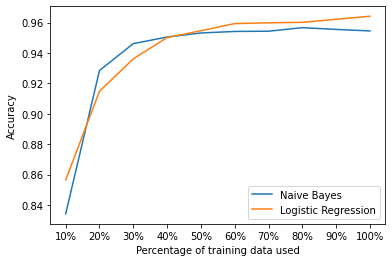

In [22]:
# compare naive bayes and logistic regression
plot_accuracies(avg_nbc_accuracies, avg_lr_accuracies)